# Usage of graphs for representing problem states

This notebook gathers several ideas involving state representation with graphs. The examples shown below revolve mainly around the topic of computation of similarity between graphs, although we will introduce the document with a few general ideas.

## Introduction

Although our intent is to contribute to the field of planning, the range of the applications of the ideas exposed here is much broader. Many problems, if not all, can be represented as graphs where the nodes are objects belonging to the world and the edges are the relations that connect them. We shall consider both labeled nodes, where the labels represent concepts or classes; and labeled edges, where the labels represent the roles of the relations. Moreover, a node (or edge) can have many labels since different concepts can described the same object. We could see this as a hierarchy of classes and roles such as those considered in ontologies (e.g. OWL). In fact, all the theory belonging to the field of ontologies is applicable:
- Inference of roles and classes in virtue of the observed relationships between objects like for instance: inverse, symmetric and transitive relations or classes that are applicable when an object (instance or individual, in the onthology argot) are observable.
- State integrity checking. In regular planning (PPDDL, PDDL, RDDL from the ICAPS competition) there is no standard mechanism to assess whether a state is valid or not according to some knowledge domain. Instead, the problem is simply described in terms of some predicates which are manipulated in planning time. Ontologies, on the other hand, provide a standard way to perform this validation and a very natural mechanism to infer additional information (predicates of a sort) in virtue of the previous point.
- In planning it has been studied how to learn the actions that are applicable in a specific domain [1]. Similarly, there are some works that deal with the challenge of learning ontologies [2]. This is: learning the hierarchy of classes, the possible relations between objects given their concepts and what can be inferred from these relations.

Another of the advantages of representing states as graphs is explored in this document: there are methods for comparing and matching graphs with roles and computing similarities in the range $[0, 1]$. These methods offer a very large of (in my view) promising possibilities, explored in the next section.


## Graph similarity

We have implemented in Python a couple of algorithms to compute matchings and similarities between graphs. These algorithms are based, in fact, on those proposed by Champin and Solnon [3] with a few improvements. In short, they consider graphs as described in the previous section, with the exception that they do not consider edges with several roles. We have throwed away this restriction. Much like them, we represent graphs with vertex ad edge descriptors, as follows:

$$ G = (V, r_V, r_E) $$
$$ r_V = \{ (v_1, {^1C_{v_1}}), (v_1, {^2C_{v_1}}), \dots, (v_2, {^1C_{v_2}}), \dots \} $$
$$ r_E = \{ (e_{1,from}, e_{1,to}, {^1R_{e_1}}), (e_{1,from}, e_{1,to}, {^2R_{e_1}}), \dots, (e_{2,from}, e_{2,to}, {^1R_{e_2}}), \dots \} $$
$$ descr(G) = r_V \cup r_E $$

Here, $ v_i, e_{j, from}, e_{j, to} \in V $, being $ V $ the set of vertices of a graph. Therefore, $ r_V $ is the set of vertex descriptors of a graph, and $ r_E $ is the set of edge descriptors. Both vertex and label descriptors are tuples whose last element is a label: a class ($ C_i $) or a role ($ R_i $), respectively. The descriptor of $ G $ is the union of $ r_V $ and $ r_E $.

Given two graphs $ G_1 $ and $ G_2 $, a mapping $ m $ is a relation in $ V_1 \times V_2 $. A vertex from $ V_1 $ can be mapped to several vertices of $ V_2 $ and viceversa. Given a mapping between two graphs, one can compute the intersection of features w.r.t. that mapping. This is represented as $ \sqcap_m $. Therefore, one can compute the similarity w.r.t. a mapping between two graphs as follows:

$$ \frac{f(descr(G_1) \sqcap_m descr(G_2)) - g(m)}{f(descr(G_1 \cup G_2))} $$.

Here $ f $ is a monotonic increasing function over the cardinality of the input set. A very simple one can be the raw cardinality of the set, while more sophisticated ones can weight the presence of each of the labels or even perform non-linear operations. $ g $ is a monotonic increasing function that penalizes certain relations. Champin and Solnon penalize exclusively the so-called splits (mappings from a single vertex to several vertex) although we consider a more general case in which relations can be arbitrarely penalized.

Therefore, the task of computing the similarity between two graphs is essentially finding the best mapping, or in other words, the set of relations that maximizes the score (numerator of the previous expression). Moreover, the found mapping provides us qualitative information that can be employed for adapting a problem in a CBR scenario.

We have implemented the Branch & Bound exhaustive algorithm proposed by the authors, with an improvement of our own (better upper bound function without loss of generality), and the greedy search technique. Both techniques have room for improvement in terms of efficiency, but we hope that the implementation seen here is illustrative. There are several usage examples after this section.

For now, let us consider some of the potential applications:
- Maintainment of a database with several cases. Each time we consider a new problem, we can extract the most similar use cases from the database and adapt their solutions to the current problem using the qualitative information of the mapping. Standard CBR scheme. This can be an alternative way of planning away from the typical searches in a graph of states.
- Apply unsupervised learning (k-medoids) to extract a set of prototypes from a training data set. Then, given another input graph, we can extract a purely numeric vector computing similitudes between this input graph and the prototypes. This vector of features can be used in standard machine learning approaches for classification and regression: neural nets, random forests, SVM, etc. Example: given a chess board classify it in a winning or losing position for the current player.
- The previous approach can be used for automatically learning a heuristic planning function tailored for a given problem. Alternatively it can be used to approximate the expected reward of a certain state in MDP.

Here there are some additional lines of research directly linked to this:

- More algorithms for computing matchings and similarities between graphs. A very interesting idea is to apply genetic algorithms, since mappings can be represented as bitstrings and standard mutation and crossover operations are immediate.
- Learning the $ f $ function. The similarity computation can be tuned. One way of training it can consist in manually specifying several scenarios: sets of source cases and a target case. For each scenario, the source case that is most similar to the target case is marked or, better yet, a ranking of source cases sorted by their similarity. Then we could use linear programming or evolutive algorithms to tune the $ f $ function so the most similar comparisons are favoured. The rationale behind using evolutive algorithms over linear programming is that some scenarios can be contradictory among them, and in such case there is no LP solution. However, EA can try that the maximum number of scenarios are satisfied.

## Examples

The first example is directly extracted from Champin and Solnon [3]. It is a very simple graph description of a physical structure.


In [1]:
from graphsim import Graph
from graphsim import graph_match_dot, default_f_score, default_g_cost
from graphsim import best_mapping, greedy_mapping, r_greedy_mapping
from IPython.core.display import display
from time import clock

def demo(graph1, graph2, method=best_mapping, f=default_f_score, g=default_g_cost, display_before=False):
    if display_before: display(graph_match_dot(graph1, graph2))
    start = clock()
    mapping, similarity = method(graph1, graph2, f, g)
    elapsed = clock() - start
    display(graph_match_dot(graph1, graph2, mapping))
    print("similarity: {:.02f}%\nelapsed: {:.03f}s".format(similarity*100, elapsed))


In [2]:
graph1 = Graph(('a', 'beam'), ('a', 'I'), ('b', 'beam'), ('b', 'I'), ('c', 'beam'),
               ('c', 'I'), ('d', 'beam'), ('d', 'I'), ('e', 'wall'), ('f', 'wall'),
               ('a', 'b', 'next_to'), ('b', 'c', 'next_to'), ('c', 'd', 'next_to'),
               ('a', 'e', 'on'), ('b', 'e', 'on'), ('c', 'f', 'on'), ('d', 'f', 'on'))

graph2 = Graph((1, 'beam'), (1, 'U'), (2, 'beam'), (2, 'U'), (3, 'beam'),
               (3, 'U'), (4, 'beam'), (4, 'U'), (5, 'wall'), (1, 2, 'next_to'),
               (2, 3, 'next_to'), (3, 4, 'next_to'), (1, 5, 'on'), (2, 5, 'on'),
               (3, 5, 'on'), (4, 5, 'on'))

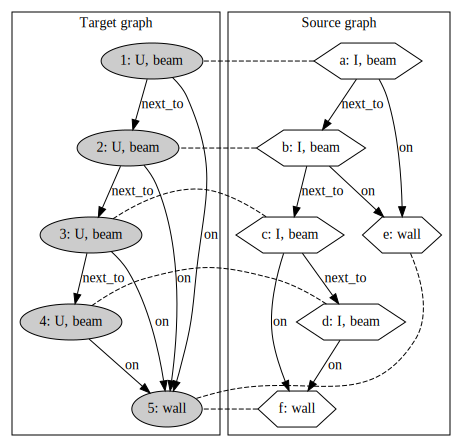

similarity: 72.73%
elapsed: 1.825s


In [3]:
demo(graph1, graph2)

The second example is an arbitrary graph without any particular meaning.

In [4]:
graph1 = Graph(('A', 'a'), ('A', 'b'), ('B', 'a'), ('C', 'b'), ('D', 'a'), ('D', 'b'),
               ('A', 'B', 'x'), ('A', 'B', 'y'), ('A', 'D', 'x'), ('A', 'D', 'z'),
               ('B', 'D', 'x'), ('B', 'D', 'y'),
               ('C', 'A', 'y'), ('C', 'B', 'x'), ('C', 'D', 'y'), ('C', 'D', 'x'))

graph2 = Graph((1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b'), (4, 'a'), (4, 'b'), (4, 'c'),
               (1, 2, 'y'), (1, 2, 'z'),
               (2, 4, 'x'), (2, 4, 'y'), (2, 4, 'z'),
               (3, 2, 'x'), (3, 4, 'x'), (3, 4, 'y'), (3, 4, 'z'), (3, 1, 'x'), (3, 1, 'y'),
               (4, 1, 'x'))

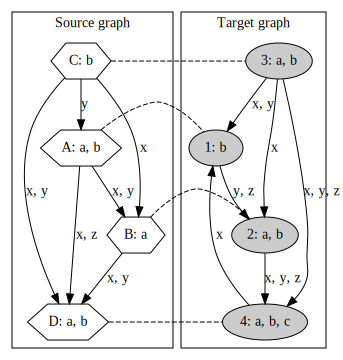

similarity: 66.67%
elapsed: 0.029s
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 55.8 ms


In [5]:
%%time
demo(graph1, graph2, g=lambda m,m_: 10000*default_g_cost(m,m_))

Finally, this is what we believe is the most interesting example. We show four chess board positions and represent them with qualitative relations in a graph. Three of these positions are sources, while the third one is a target. Then we use the described method to see which of the source cases is most similar to the target.

In [6]:
import chess

piece_types = [None, 'Pawn', 'Knight', 'Bishop', 'Rook', 'Queen', 'King']

def get_all_pieces(board):
    pieces = list()
    for row, column in ((row, column) for row in range(8) for column in range(8)):
        piece = board.piece_at(row*8 + column)
        if piece:
            color = 'White' if piece.color == chess.WHITE else 'Black'
            pieces.append((row, column, piece_types[piece.piece_type], color))
    return pieces

def is_diagonal(piece1, piece2):
    return abs(piece1[0] - piece2[0]) == abs(piece1[1] - piece2[1])

def is_same_row(piece1, piece2):
    return piece1[0] == piece2[0]

def is_same_col(piece1, piece2):
    return piece1[1] == piece2[1]

def is_in_front_of(piece1, piece2):
    return piece1[0] > piece2[0]

def is_behind_of(piece1, piece2):
    return piece1[0] < piece2[0]

def is_at_the_right_of(piece1, piece2):
    return piece1[1] > piece2[1]

def is_at_the_left_of(piece1, piece2):
    return piece1[1] < piece2[1]

def is_adjacent(piece1, piece2):
    return max(abs(piece1[0] - piece2[0]), abs(piece1[1] - piece2[1])) <= 1

def board_features(board, negative_idx=False):
    pieces = get_all_pieces(board)
    features = list()
    for idx, piece1 in enumerate(pieces):
        idx += 1
        if negative_idx: idx = -idx
        features.append((idx, 'Piece'))
        features.append((idx, piece1[2]))
        features.append((idx, piece1[3]))
        for jdx, piece2 in enumerate(pieces):
            jdx += 1
            if negative_idx: jdx = -jdx
            if idx == jdx: continue
            if is_diagonal(piece1, piece2): features.append((idx, jdx, 'diag'))
            if is_same_row(piece1, piece2): features.append((idx, jdx, 'row'))
            if is_same_col(piece1, piece2): features.append((idx, jdx, 'col'))
            if is_in_front_of(piece1, piece2): features.append((idx, jdx, 'fore'))
            if is_behind_of(piece1, piece2): features.append((idx, jdx, 'behind'))
            if is_at_the_right_of(piece1, piece2): features.append((idx, jdx, 'rhs'))
            if is_at_the_left_of(piece1, piece2): features.append((idx, jdx, 'lhs'))
            if is_adjacent(piece1, piece2): features.append((idx, jdx, 'adj'))
    return features

source 1


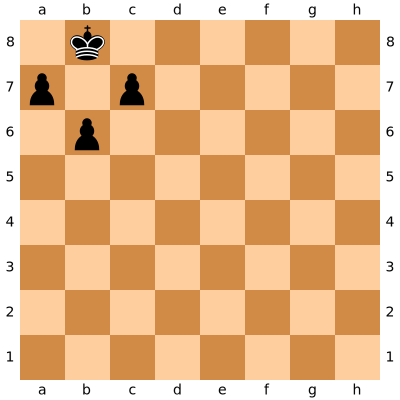

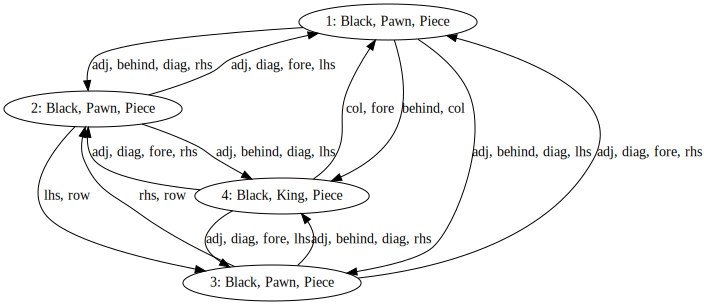

source 2


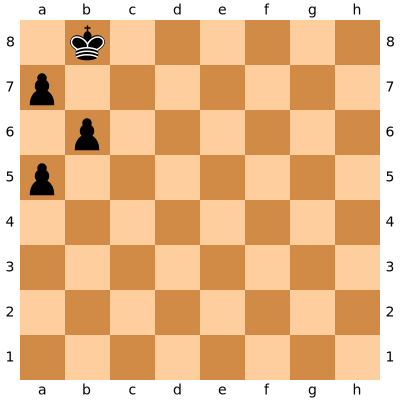

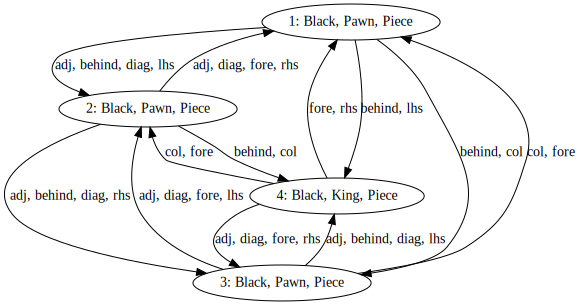

source 3


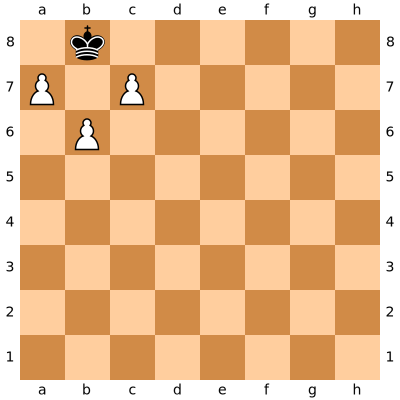

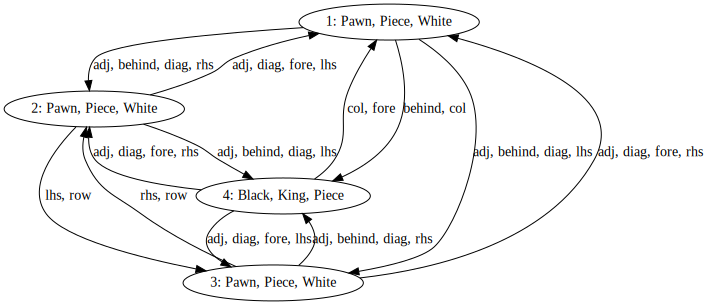

target


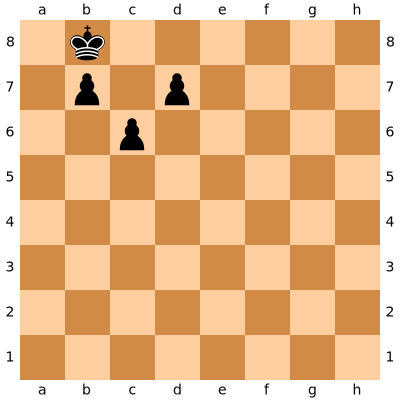

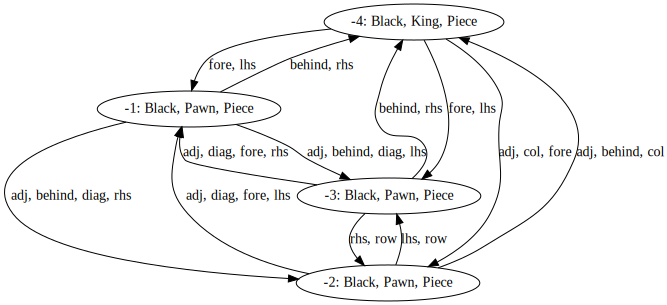

In [7]:
# A much cooler example!!

board1 = chess.Board(fen='1k6/p1p5/1p6/8/8/8/8/8 w KQkq - 1 0')
board2 = chess.Board(fen='1k6/p7/1p6/p7/8/8/8/8 w KQkq - 1 0')
board3 = chess.Board(fen='1k6/P1P5/1P6/8/8/8/8/8 w KQkq - 1 0')
board4 = chess.Board(fen='1k6/1p1p4/2p5/8/8/8/8/8 w KQkq - 1 0')

graph1 = Graph(*board_features(board1))
graph2 = Graph(*board_features(board2))
graph3 = Graph(*board_features(board3))
graph4 = Graph(*board_features(board4, True))

print("source 1")
display(board1)
display(graph1)
print("source 2")
display(board2)
display(graph2)
print("source 3")
display(board3)
display(graph3)
print("target")
display(board4)
display(graph4)

Notice that we modify the $ f $, $ g $ functions so they have more sense in this case. Specifically, we strongly penalize the mappings from a single piece to several ones, since this does not make much sense in this particular example. On the other hand, we modify the $ f $ function so it gives more relevance to the colour of the pieces and to the "adj" role. We can see that these decisions render the first source case the most similar to the target case.

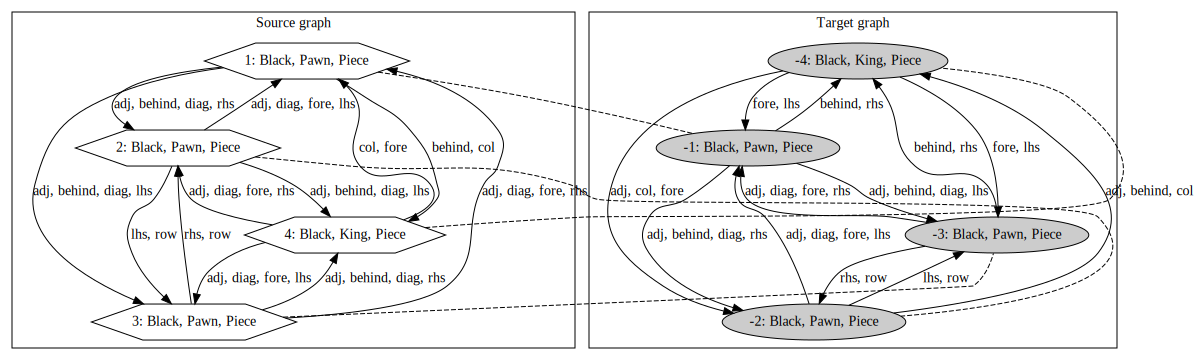

similarity: 92.81%
elapsed: 0.032s


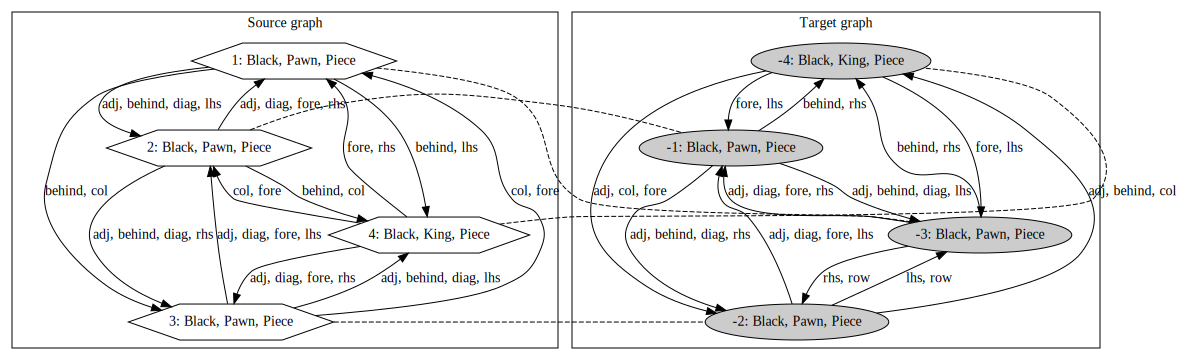

similarity: 89.80%
elapsed: 0.030s


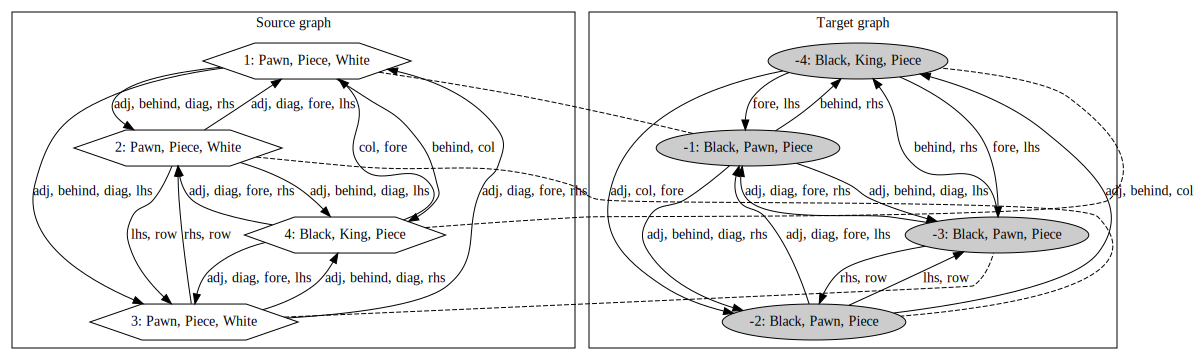

similarity: 53.59%
elapsed: 0.030s
CPU times: user 100 ms, sys: 8 ms, total: 108 ms
Wall time: 185 ms


In [8]:
%%time

strong_split_penalization = lambda m, m_inv: 1e6*default_g_cost(m, m_inv)

def custom_chess_f(direct, inverse):
    value = 0
    for feature in direct:
        if feature[-1] in ('White', 'Black'): value += 20
        elif feature[-1] == 'adj': value += 5
        else: value +=1
    for feature in inverse:
        if feature[-1] in ('White', 'Black'): value += 20
        elif feature[-1] == 'adj': value += 5
        else: value +=1
    return value


demo(graph1, graph4, f=custom_chess_f, g=strong_split_penalization)
demo(graph2, graph4, f=custom_chess_f, g=strong_split_penalization)
demo(graph3, graph4, f=custom_chess_f, g=strong_split_penalization)

## Usage of Genetic Algorithms



In [9]:
from importlib import reload
from graphsim import ga_deap
import random
import matplotlib.pyplot as plt
reload(ga_deap)

# strong_split_penalization = lambda m, m_inv: 1e6*default_g_cost(m, m_inv)

def plot_evolution(log, filename=None):
    gen, mean_gen, min_gen, max_gen = log.select("gen", "mean", "min", "max")
    fig, ax = plt.subplots(1)
    ax.fill_between(gen, min_gen, max_gen, facecolor='red', alpha=0.25)
    line1 = ax.plot(gen, mean_gen, 'r')
    ax.legend(line1, ('Average',), loc='lower right')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Score')
    ax.set_title('Evolution of fitness over time. Maximum fitness: {}'.format(max(max_gen)))
    ax.grid('on')
    if filename:
        plt.savefig(filename)
    plt.show()

/home/sprkrd/.local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/sprkrd/.local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


B&B (optimum)


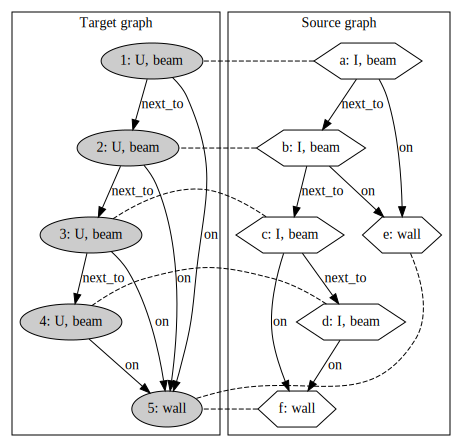

similarity: 72.73%
elapsed: 1.820s

Genetic Algorithm


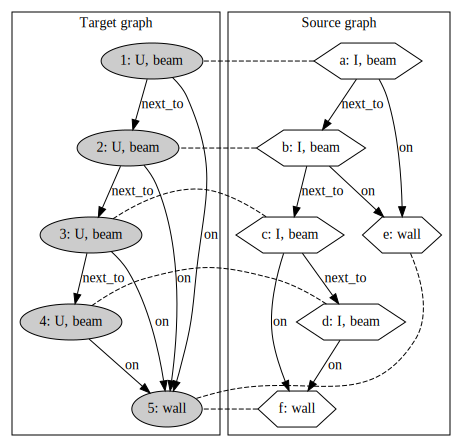

similarity: 72.73%
elapsed: 0.463s

Greedy Algorithm


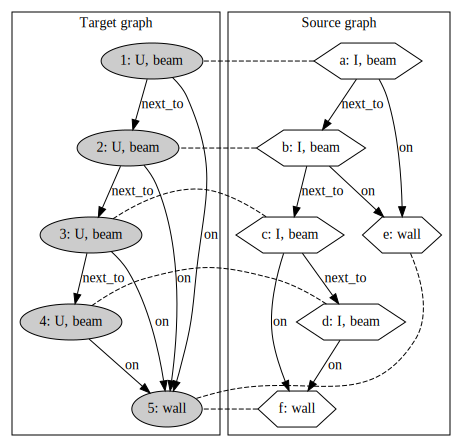

similarity: 72.73%
elapsed: 0.006s


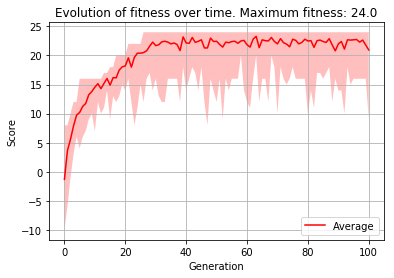

In [10]:
graph1 = Graph(('a', 'beam'), ('a', 'I'), ('b', 'beam'), ('b', 'I'), ('c', 'beam'),
               ('c', 'I'), ('d', 'beam'), ('d', 'I'), ('e', 'wall'), ('f', 'wall'),
               ('a', 'b', 'next_to'), ('b', 'c', 'next_to'), ('c', 'd', 'next_to'),
               ('a', 'e', 'on'), ('b', 'e', 'on'), ('c', 'f', 'on'), ('d', 'f', 'on'))

graph2 = Graph((1, 'beam'), (1, 'U'), (2, 'beam'), (2, 'U'), (3, 'beam'),
               (3, 'U'), (4, 'beam'), (4, 'U'), (5, 'wall'), (1, 2, 'next_to'),
               (2, 3, 'next_to'), (3, 4, 'next_to'), (1, 5, 'on'), (2, 5, 'on'),
               (3, 5, 'on'), (4, 5, 'on'))

# Compare algorithms in this small example

parameters = {
    'mu': 20,
    'max_fitness_eval': 2000,
    'cxpb': 0.6666,
    'mutpb': 0.6666,
    'mutation_strength': 1,
    'method': 'simple',
    'p': 0.5,
    'track_statistics': False
}

ga_algorithm = lambda graph1, graph2, f, g: ga_deap.ga_mapping(graph1, graph2, f, g, **parameters)

print("B&B (optimum)")
demo(graph1, graph2, method=best_mapping)
print("\nGenetic Algorithm")
random.seed(45)
demo(graph1, graph2, method=ga_algorithm)
print("\nGreedy Algorithm")
random.seed(45)
demo(graph1, graph2, method=greedy_mapping)

parameters['track_statistics'] = True
random.seed(45)
mapping, similarity, log = ga_algorithm(graph1, graph2, default_f_score, default_g_cost)

plot_evolution(log)

In [11]:
from math import sqrt
import random
import matplotlib.pyplot as plt
from copy import deepcopy

def generate_road_map(n):
    x = [random.random()*10-5 for _ in range(n)]
    y = [random.random()*10-5 for _ in range(n)]
    colors = [random.choice(['red', 'green', 'blue', 'yellow']) for _ in range(n)]
    return list(zip(x,y,colors))

def plot_road_map(rm, filename=None):
    fig, ax = plt.subplots()
    for x, y, _ in rm:
        distances = [(sqrt((x-_x)**2 + (y-_y)**2), idx) for idx, (_x, _y, _) in enumerate(rm)]
        distances.sort()
        for _, idx in distances[1:5]:
            plt.plot([x, rm[idx][0]], [y, rm[idx][1]], 'k', alpha=0.25, zorder=0)
    for idx, (x, y, color) in enumerate(rm):
        plt.scatter(x, y, facecolor=color, zorder=1)
        plt.annotate(str(idx+1), (x+0.1, y+0.1))
            
    plt.grid('on')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
        
def make_graph_from_road_map(rm, idx0=1):
    features = list()
    for idx, (x, y, color) in enumerate(rm):
        _idx = idx + idx0
        features.append((_idx, 'Point'))
        features.append((_idx, color))
    for idx, (x, y, _) in enumerate(rm):
        _idx = idx + idx0
        distances = [(sqrt((x-_x)**2 + (y-_y)**2), jdx) for jdx, (_x, _y, _) in enumerate(rm)]
        distances.sort()
        for _, jdx in distances[1:5]:
            _jdx = jdx + idx0
            features.append((_idx, _jdx, ''))
    return Graph(*features)

def add_uniform_noise(x, var):
    scale = sqrt(12*var)
    return x + scale*random.random() - scale/2

def random_changes(rm, pbrem=0.1, pbchange=0.1, pbadd=0.5, var=0.0025):
    rm2 = list()
    for x, y, color in rm:
        if random.random() < pbrem:
            continue
        elif random.random() < pbrem + pbchange:
            colors = ['red', 'green', 'blue', 'yellow']
            colors.remove(color)
            new_color = random.choice(colors)
            rm2.append((add_uniform_noise(x, var), add_uniform_noise(y, var), new_color))
        else:
            rm2.append((add_uniform_noise(x, var), add_uniform_noise(y, var), color))
    while random.random() < pbadd:
        x = random.random()*10 - 5
        y = random.random()*10 - 5
        color = random.choice(['red', 'green', 'blue', 'yellow'])
        rm2.append((x, y, color))
    return rm2

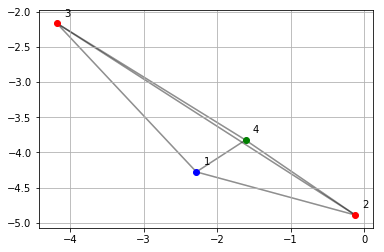

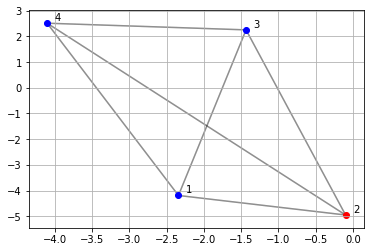

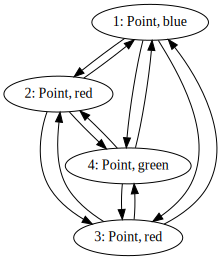

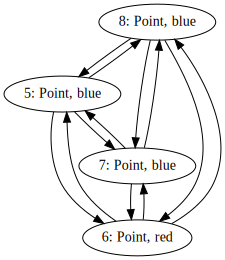

In [12]:
random.seed(45)

rm = generate_road_map(4)
rm2 = random_changes(rm)
plot_road_map(rm)
plot_road_map(rm2)
graph1 = make_graph_from_road_map(rm)
graph2 = make_graph_from_road_map(rm2, idx0=len(rm)+1)
display(graph1)
display(graph2)

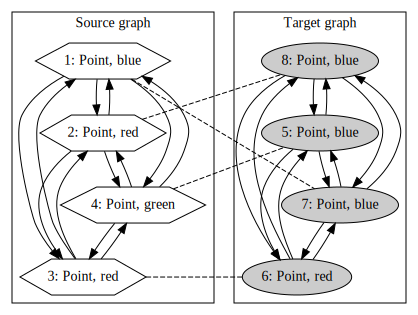

similarity: 90.00%
elapsed: 0.232s


In [13]:
demo(graph1, graph2)

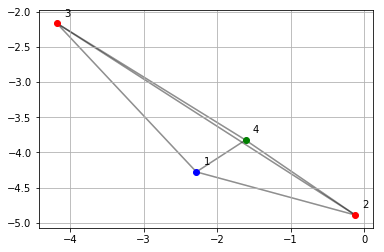

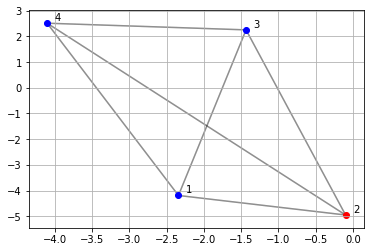

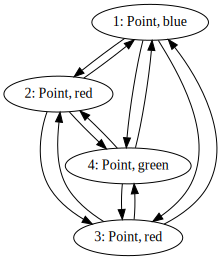

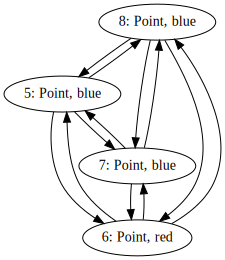

B&B (optimum)


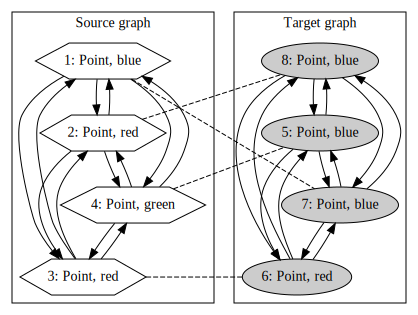

similarity: 90.00%
elapsed: 0.234s

Genetic Algorithm


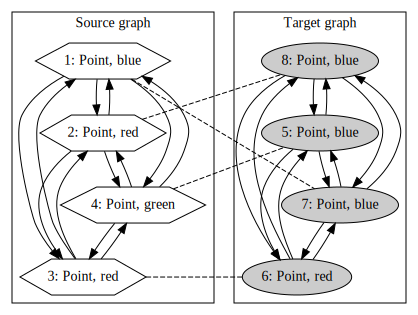

similarity: 90.00%
elapsed: 0.383s

Greedy Algorithm


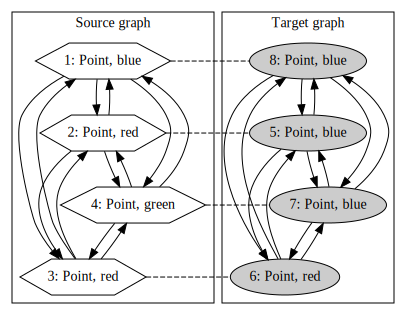

similarity: 90.00%
elapsed: 0.005s


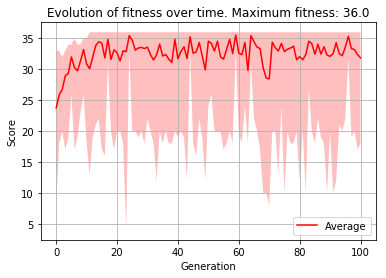

In [14]:
random.seed(45)
rm = generate_road_map(4)
rm2 = random_changes(rm)
plot_road_map(rm)
plot_road_map(rm2)
graph1 = make_graph_from_road_map(rm)
graph2 = make_graph_from_road_map(rm2, idx0=len(rm)+1)
display(graph1)
display(graph2)

# compare again

ga_algorithm = lambda graph1, graph2, f, g: ga_deap.ga_mapping(graph1, graph2, f, g, **parameters)

parameters['track_statistics'] = False

print("B&B (optimum)")
demo(graph1, graph2, method=best_mapping)
print("\nGenetic Algorithm")
random.seed(45)
demo(graph1, graph2, method=ga_algorithm)
print("\nGreedy Algorithm")
random.seed(45)
demo(graph1, graph2, method=greedy_mapping)

parameters['track_statistics'] = True
random.seed(45)
mapping, similarity, log = ga_algorithm(graph1, graph2, default_f_score, default_g_cost)

plot_evolution(log)

## References

0. D. Martínez, G. Alenyà, and C. Torras, “V-MIN : Efficient Reinforcement Learning through Demonstrations and Relaxed Reward Demands,” Proc. 29th AAAI Conf. Artif. Intell., no. 2010, pp. 2857–2863, 2015.
0. M. L. M. Li, X.-Y. D. X.-Y. Du, and S. W. S. Wang, “Learning ontology from relational database,” 2005 Int. Conf. Mach. Learn. Cybern., vol. 6, no. August, pp. 18–21, 2005.
0. P. Champin and C. Solnon, “Measuring the similarity of labeled graphs,” in International Conference on Case-Based Reasoning, 2003, pp. 80–95.